# Initial Work for Test Network


## Notebook Setup

<div hidden>
$\usepackage{cancel}$
$\usepackage{amssymb}$
</div>

In [1]:
# Required packages
#!pip install torch torchvision pandas numpy matplotlib scipy plotly tensorboard onyx

In [2]:
# Visualize tensorboard in the notebook
%load_ext tensorboard
# In order to force reload any changes done to the models package files
%load_ext autoreload
%autoreload 2

In [3]:
from models.simpleFork import Simple, Fork
from models.danmf import DANMF
from datasets.yt_vidframes import YtVidsDataset

import os
from collections import namedtuple
from timeit import default_timer
import re
from datetime import datetime

import torch
import onnx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import svd, diagsvd
from torch import nn
from torch.utils.data import DataLoader, random_split
# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from torch import profiler

### Per-run user defined variables

In [4]:
# Define the machine being used
# machine = "Macbook"
machine = "PC"

## FORMAT: {machine}, {model}, {datetime}
state_dict_str = "{}_{}_state-dict_{}.pt"
state_dict_notime = "{}_{}_state-dict"
checkpoint_dict_str = "{}_{}_checkpoint_{}.tar"
checkpoint_dict_notime = "{}_{}_checkpoint"

Checkpoint = namedtuple("Checkpoint", ["model", "epoch", "loss", "validation_loss", "opt_state_dict", "train_time"])
# data_dir = os.path.join("..", "data")
# output_dir = os.path.join(data_dir, "output")
data_dir = os.path.join("..", "data")
output_dir = os.path.join(data_dir, "output")
imgs_dir = os.path.join(data_dir, "images_96x54")


## Data 

We remove the channels in the images (convert to grayscale) to more closely mimic the actual plasma dataset

* [Helpful Link](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

#### Data Augmentation
TODO: Cropping, rotating, scaling, reflecting

#### Normalization
* Normalize each image with respect to its unit Frobenius norm

### Dataset

In [5]:
batch_size = 5

# Load and split the data, and prep for being fed into the NN
data = YtVidsDataset(imgs_dir)
# Divide data into train, validation, test
train_data, validation_data, test_data = random_split(data, [0.7, 0.2, 0.1])
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=(torch.cuda.is_available()), drop_last=True)
validation_dataloader = DataLoader(validation_data, batch_size=batch_size, shuffle=True, pin_memory=(torch.cuda.is_available()), drop_last=True)

6741 <class 'torch.Tensor'> torch.Size([54, 96])
tensor([[0.0160, 0.0155, 0.0152,  ..., 0.0163, 0.0162, 0.0162],
        [0.0156, 0.0158, 0.0155,  ..., 0.0160, 0.0159, 0.0158],
        [0.0148, 0.0154, 0.0150,  ..., 0.0158, 0.0157, 0.0156],
        ...,
        [0.0147, 0.0146, 0.0145,  ..., 0.0140, 0.0136, 0.0141],
        [0.0147, 0.0146, 0.0145,  ..., 0.0140, 0.0136, 0.0141],
        [0.0146, 0.0146, 0.0145,  ..., 0.0140, 0.0136, 0.0142]])


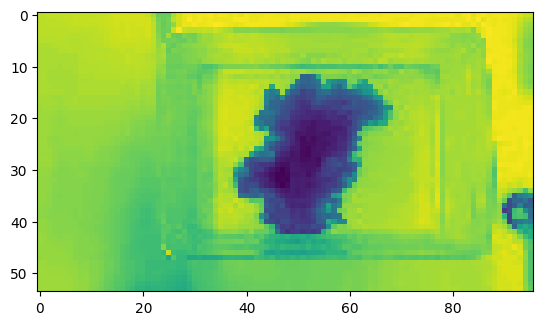

In [6]:
plt.imshow(data[2669])
print(len(data), type(data[0]), data[244].shape)
print(data[2000])

## Hyperparameters


### Structure

#### DANMF Implementation from papers

* **Non-alternating/nonnegative Matrix Factorization (NMF)**: Classical deep NMF for a non-negative matrix X ∈ Rm×n + can be described as follows: first, X is decomposed as X ≈ U0V 0 where U 0 ∈ Rm×r0 +  and V 0 ∈ Rr0×n + . The coding matrix V 0 is then further decomposed as V 0 ≈ U 1V 1 where U 1 ∈ Rr0×r1 +  and V 1 ∈ Rr1×n +. The procedure is repeated until a pre-fixed number of layers is reached. [[2]](#r2)
* **deep alternating non-negative matrix factorisation (DA-NMF)**: we propose to factorise the basis and coding matrices in an alternating order along the layers. [[2]](#r2)
    * Uses approx 6-8 layers

<img src="images/r2_fig1.png" alt="Drawing" style="width: 400px;"/>
<!-- ![image.png](images/r2_fig1.png) -->


### L-System
* Using L (Lindenmayer) Systems to define strucure?
* Node types:
    * Terminating (1 -> 0)
    * Splitting (1 -> 2)
    * Unifying (2 ->1)
    * Direct (1 -> 1)
    * Starting (0 -> 1)


### Loss Function
We use methods defined in [[1]](#r1) to define our loss function <!-- $\mathcal{L}$ \\ -->

$$
\min_{\substack{U \in \real^{m\times r} \\ V \in \real^{r\times n}}} ||X - ReLU(UV)||^2_F ,
$$
Where we are finding the square Frobenius norm of the difference between the original matrix $X$ and the rectified linear low rank representation matrices $UV$

#### From paper

Eq. 10-11 [[2]](#r2)

TODO


### Optimizer

Adam?



## TODO

* compare against SVD 4, using rank 6 for NN (or bigger)
* Use a different algo where we pre-give the rank, better alg: `scipy.sparse.linalg.svds`, tol=0.001
* Go as big as I can, log space increase in size
* Warm starting (initializing) the SVD algorithm, using the NN for the warm start
    * `scipy.linalg.qr`
    * Randomized Numerical Linear Algebra: Foundations & Algorithms (Per-Gunnar Martinsson, University of Texas at Austin Joel A. Tropp, California Institute of Technology)
* Compare rank vs err (loss) for SVD vs NN, and see how many more ranks it is to get comparable err


## Model Definition

### General params

In [7]:
# Select device to use for compute power
device = (
    "cuda"
    if torch.cuda.is_available()
    # else "mps"
    # if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")
use_cuda = device == "cuda"

# Params
img_size = (54, 96)
rank = 6

Using cuda device


### Various Models

### Model: Variations

TODO:
* ~Simple with no nonnegativity constraints (sigmoid activation)~
    * ~Allow negativity at every step except after UV, aka ReLU(UV) or |UV| (relu better)~
* ~Different activation layers~
* ~Different structure~
    * ~Try forking at beginning~
* Define new layer
    * Instead of flattening and using a linear layer, doing a either side multiply of the matrix input: A\*X\*B where A: n_1 x m, X: m x n, B: n x n_2
* try 2d convolutional layers

In [8]:
# layer_dims = (500, 400, 300, 200, 100, 100)

model_fork = Fork().to(device)
print(model_fork)
print(model_fork.get_name(), model_fork.get_hyperparameters())



Fork(
  (input): Flatten(start_dim=1, end_dim=-1)
  (seq): Sequential(
    (0): Sequential(
      (0): Linear(in_features=5184, out_features=500, bias=True)
      (1): Tanh()
    )
    (1): Sequential(
      (0): Linear(in_features=500, out_features=400, bias=True)
      (1): Tanh()
    )
    (2): Sequential(
      (0): Linear(in_features=400, out_features=300, bias=True)
      (1): Tanh()
    )
    (3): Sequential(
      (0): Linear(in_features=300, out_features=200, bias=True)
      (1): Tanh()
    )
  )
  (U): Sequential(
    (0): Sequential(
      (0): Linear(in_features=200, out_features=300, bias=True)
      (1): Tanh()
    )
    (1): Sequential(
      (0): Linear(in_features=300, out_features=200, bias=True)
      (1): Tanh()
    )
    (2): Sequential(
      (0): Linear(in_features=200, out_features=100, bias=True)
      (1): Tanh()
    )
    (3): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): Tanh()
    )
    (4): Sequential(
      (0): L

In [9]:
model_danmf = DANMF().to(device)
print(model_danmf)

writer = SummaryWriter(os.path.join(output_dir, "runs", f'{machine}_{model_danmf.get_name()}_faster'))
writer.add_graph(model_danmf, next(iter(train_dataloader)).to(device))
writer.flush()

DANMF(
  (input): Flatten(start_dim=1, end_dim=-1)
  (U): ModuleDict(
    (0): Sequential(
      (0): Linear(in_features=5184, out_features=8100, bias=True)
      (1): Unflatten(dim=1, unflattened_size=(54, 150))
      (2): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=15000, out_features=10500, bias=True)
      (1): Unflatten(dim=1, unflattened_size=(150, 70))
      (2): ReLU()
    )
    (4): Sequential(
      (0): Linear(in_features=3500, out_features=2100, bias=True)
      (1): Unflatten(dim=1, unflattened_size=(70, 30))
      (2): ReLU()
    )
    (5): Sequential(
      (0): Linear(in_features=1500, out_features=300, bias=True)
      (1): Unflatten(dim=1, unflattened_size=(30, 10))
    )
  )
  (V): ModuleDict(
    (1): Sequential(
      (0): Linear(in_features=14400, out_features=9600, bias=True)
      (1): Unflatten(dim=1, unflattened_size=(100, 96))
      (2): ReLU()
    )
    (3): Sequential(
      (0): Linear(in_features=7000, out_features=5000, bias=True)
   

## Running the model

### Save/Load checkpoints

In [10]:
def load_checkpoint(mname, machine, checkpoint_str=checkpoint_dict_notime, statedict_str=state_dict_notime):
    checkpoint_dict, statedict = (None, None)
    
    if checkpoint_str:
        name_checkpoint = checkpoint_dict_notime.format(machine, mname)
        file_checkpoint = next((x for x in sorted(os.listdir(output_dir)) if x.startswith(name_checkpoint)), None)
        if file_checkpoint:
            print(f"Found checkpoint to load. Using: {file_checkpoint}")
            checkpoint_dict = torch.load(os.path.join(output_dir, file_checkpoint))

    if statedict_str:  
        name_statedict = state_dict_notime.format(machine, mname)
        file_statedict = next((x for x in sorted(os.listdir(output_dir)) if x.startswith(name_statedict)), None)
        if file_statedict:
            print(f"Found model state dict to load. Using: {file_statedict}")
            statedict = torch.load(os.path.join(output_dir, file_statedict))
            
    return checkpoint_dict, statedict

### Training

In [11]:
def loss_fcn(X, U, V):
    return torch.mean(
            torch.square(
                torch.linalg.matrix_norm(X - nn.functional.relu(torch.bmm(U, V)),
                # Don't enforce non-negativity on UV?
                # torch.linalg.matrix_norm(X - torch.bmm(U, V), 
                                         ord='fro')))


def train_model(epochs, model, optimizer, checkpoint_at = 3, load = True, batch_pr = 200, writer=None, profiler=None): # loop over the dataset multiple times
    mname = model.get_name()
    start_epoch = -1

    print(f"Training {mname}")
    
    # Attempt to load the previous checkpoint
    if load:
        checkpoint, statedict = load_checkpoint(mname, machine)
        if checkpoint and statedict:
            start_epoch = checkpoint["epoch"]
            optimizer.load_state_dict(checkpoint["opt_state_dict"])
            model.load_state_dict(statedict)
        else:
            print("No checkpoint found to load. Using base model")
            

    # Save basic hyperparams
    if writer:
        writer.add_hparams(model.get_hyperparameters(), {})
        writer.flush()

    loss_arr = []
    validation_arr = []
    time_arr = []
    for e in range(start_epoch+1, start_epoch+1 + epochs ):
        model.train()
        running_loss = 0.0
        running_time = 0.0
        
        for i, data in enumerate(train_dataloader, 0):
            data = data.to(device)

            # Write out a view of the NN graph, just once
            if writer and e == 0 and i == 0:
                writer.add_graph(model, data)
                writer.flush()
                torch.onnx.export(model, data, os.path.join(output_dir, f'{mname}_model.onnx'), input_names=["matrix"], output_names=["V", "U"])

            start_time = default_timer()
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            U, V = model(data)
            # Loss function
            loss = loss_fcn(data, U, V)
            loss.backward()
            optimizer.step()
            running_time = default_timer() - start_time

            running_loss += loss.item()
            # Print and save statistics
            if i % batch_pr == batch_pr - 1:    # print every 200 mini-batches
                avg_loss = running_loss / batch_pr 
                loss_arr.append(avg_loss)
                avg_time = running_time / batch_pr
                time_arr.append(avg_time)
                
                # Determine validation loss
                model.eval()
                model.train(False)
                v_arr = []
                for v_data in validation_dataloader:
                    v_data = v_data.to(device)
                    U_v, V_v = model(v_data)
                    v_arr.append(loss_fcn(v_data, U_v, V_v).item())
                validation_arr.append(np.mean(v_arr))
                model.train(True)

                # Write out stats
                print(f"[{e}, {i+1}] loss: {avg_loss}, validation loss: {validation_arr[-1]}, average train time (sec): {avg_time}")
                if writer:
                    writer.add_scalars('Training vs. Validation Loss',
                            { 'Training' : avg_loss, 'Validation' : validation_arr[-1] },
                            e * len(train_dataloader) + i)
                    writer.add_scalar('Average Train Time (s)', avg_time, e * len(train_dataloader) + i)
                    writer.flush()

                running_loss = 0.0
                running_time = 0.0

            if profiler:
                profiler.step()
        
        # Save output to checkpoint dict
        if e % checkpoint_at == checkpoint_at - 1:
            dt = datetime.now().strftime('%Y-%m-%d_%H%M%S')
            save = Checkpoint(mname, e, loss_arr, validation_arr, optimizer.state_dict(), time_arr)._asdict()
            torch.save(save, os.path.join(output_dir, checkpoint_dict_str.format(machine, mname, dt)))
            torch.save(model.state_dict(), os.path.join(output_dir, state_dict_str.format(machine, mname, dt)))
            print(f"Saved checkpoint for epoch {e}: {machine}_{mname}")
            loss_arr = []
            validation_arr = []
            time_arr = []
    
    print('Finished Training')

# TODO: Pad input when not enough imgs for batch 
##  torch.nn.functional.pad(input, pad, mode='constant', value=None) → Tensor

def trace_handler(prof):
    table = prof.key_averages().table(sort_by="self_cuda_time_total" if use_cuda else "self_cpu_time_total", row_limit=10)
    print(table)
    # ff = prof.key_averages()
    # df_table = pd.DataFrame(ff)
    # print(df_table)
    # df_table.to_csv("tst.csv")
    
    ## TODO: save to file, and tensorboard

### Model hyperparameters to try

In [12]:
models = []
# ranks = (6, 10, 15)
nn_rank = 10

stem_layer_dims = [[500, 200],
                   [200, 500], 
                  ]
fork_layer_dims = [[300, 200],
                   [200, 300],
                  ]

# for r in ranks:
for sl in stem_layer_dims:
    for fl in fork_layer_dims:
        m = Fork(nn_rank, img_size, sl, fl).to(device)
        print(f"rank = {nn_rank}, \t sl={sl}, \t fl={fl}", m.get_name())
        models.append(m)
            

rank = 10, 	 sl=[500, 200], 	 fl=[300, 200] Fork_r10_sdim2-3ebc_fdim2-fd85
rank = 10, 	 sl=[500, 200], 	 fl=[200, 300] Fork_r10_sdim2-3ebc_fdim2-37e7
rank = 10, 	 sl=[200, 500], 	 fl=[300, 200] Fork_r10_sdim2-c877_fdim2-fd85
rank = 10, 	 sl=[200, 500], 	 fl=[200, 300] Fork_r10_sdim2-c877_fdim2-37e7


### Run models

In [13]:
for model in models:
    writer = SummaryWriter(os.path.join(output_dir, "runs", f'{machine}_{model.get_name()}_ED'))
    # Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    
    train_model(15, model, optimizer, checkpoint_at=15, writer=writer, load=False)

Training Fork_r10_sdim2-3ebc_fdim2-fd85
[0, 200] loss: 0.15067550369538366, validation loss: 0.036248075813885956, average train time (sec): 8.544999946025201e-06
[0, 400] loss: 0.030713832792825996, validation loss: 0.025808592527744718, average train time (sec): 7.123999967006966e-06
[0, 600] loss: 0.027846601363271474, validation loss: 0.021297403602587358, average train time (sec): 7.322000019485131e-06
[0, 800] loss: 0.02138876557117328, validation loss: 0.01886102127527548, average train time (sec): 7.718999986536801e-06
[1, 200] loss: 0.016892575449310242, validation loss: 0.01616922081846287, average train time (sec): 7.636500013177284e-06
[1, 400] loss: 0.018169029504060744, validation loss: 0.015517401983303652, average train time (sec): 6.8390000524232165e-06
[1, 600] loss: 0.015770028370898217, validation loss: 0.014315189707151798, average train time (sec): 6.919000006746501e-06
[1, 800] loss: 0.015185775707941503, validation loss: 0.01403325367511205, average train time (

In [12]:
model = model_danmf



writer = SummaryWriter(os.path.join(output_dir, "runs", f'{machine}_{model.get_name()}'))

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


# with profiler.profile(activities=[profiler.ProfilerActivity.CPU, profiler.ProfilerActivity.CUDA] if use_cuda else [profiler.ProfilerActivity.CPU],
#                          record_shapes=False, 
#                          profile_memory=True, 
#                          # use_cuda=use_cuda,
#                          schedule=torch.profiler.schedule(
#                             wait=1,
#                             warmup=1,
#                             active=2,
#                             repeat=1),
#                          on_trace_ready=trace_handler
#                          ) as prof:
#         with profiler.record_function("train_model"):
#             train_model(15, model, optimizer, checkpoint_at=5, writer=writer, load=False, profiler=prof)

            
train_model(15, model, optimizer, checkpoint_at=5, writer=writer, load=False)



Training DANMF
[0, 200] loss: 0.9960014140605926, validation loss: 0.9970276003433426, average train time (sec): 1.6379500011680647e-05
[0, 400] loss: 0.9980015271902084, validation loss: 0.9970275981275566, average train time (sec): 1.8287000129930676e-05
[0, 600] loss: 0.998001449406147, validation loss: 0.9970275983491351, average train time (sec): 1.5316999924834817e-05
[0, 800] loss: 0.9950014379620552, validation loss: 0.9970275914801984, average train time (sec): 1.555850001750514e-05
[1, 200] loss: 0.9970016086101532, validation loss: 0.997027596798085, average train time (sec): 1.5921500016702338e-05
[1, 400] loss: 0.997001425921917, validation loss: 0.9970275970196635, average train time (sec): 1.588699989952147e-05
[1, 600] loss: 0.9970014894008636, validation loss: 0.997027599013871, average train time (sec): 1.4579499984392896e-05
[1, 800] loss: 0.9970014449954033, validation loss: 0.9970275934744058, average train time (sec): 1.7250000091735273e-05
[2, 200] loss: 0.996001

### Setup to run against SVD

In [15]:
# list(model_neg.parameters())
# optimizer.__class__.__name__
rank = 10
stem_layer_dims=[500, 200] 
fork_layer_dims=[200, 300]

model = Fork(nn_rank, img_size, stem_layer_dims, fork_layer_dims).to(device)

_, statedict = load_checkpoint(model.get_name(), machine, checkpoint_str="")
model.load_state_dict(statedict)

print(model, model.get_name())
prof_events = None

# def save_prof(prof):
#     prof_events = prof.key_averages()

# with profiler.profile(activities=[profiler.ProfilerActivity.CPU, profiler.ProfilerActivity.CUDA] if use_cuda else [profiler.ProfilerActivity.CPU],
#                          record_shapes=False, 
#                          profile_memory=True,
#                       on_trace_ready=save_prof
#                          ) as prof:
#     U, V = model(next(iter(validation_dataloader)))
#     prof.step()
#     prof_events = prof.key_averages()

prof_events

writer = SummaryWriter(os.path.join(output_dir, "runs", f'{machine}_{model.get_name()}_ED'))

Found model state dict to load. Using: PC_Fork_r10_sdim2-3ebc_fdim2-37e7_state-dict_2023-11-21_143047.pt
Fork(
  (input): Flatten(start_dim=1, end_dim=-1)
  (seq): Sequential(
    (0): Sequential(
      (0): Linear(in_features=5184, out_features=500, bias=True)
      (1): Tanh()
    )
    (1): Sequential(
      (0): Linear(in_features=500, out_features=200, bias=True)
      (1): Tanh()
    )
  )
  (U): Sequential(
    (0): Sequential(
      (0): Linear(in_features=200, out_features=200, bias=True)
      (1): Tanh()
    )
    (1): Sequential(
      (0): Linear(in_features=200, out_features=300, bias=True)
      (1): Tanh()
    )
    (2): Sequential(
      (0): Linear(in_features=300, out_features=540, bias=True)
      (1): Unflatten(dim=1, unflattened_size=(54, 10))
    )
  )
  (V): Sequential(
    (0): Sequential(
      (0): Linear(in_features=200, out_features=200, bias=True)
      (1): Tanh()
    )
    (1): Sequential(
      (0): Linear(in_features=200, out_features=300, bias=True)
 

In [38]:
prof_events

In [ ]:
f= {"F": 2, "G": 4, "d": 6}
for k in f:
    print(k)

print(int("5"))

## Comparision against base

Compare against some python implementation of SVD that produces U: m x r V: r x n matrices

<img src="images/rank_vs_err.png" alt="Rank vs Error Plot" style="width: 600px;"/>

In [39]:
g = [1, 3, 4]
np.array(g)

array([1, 3, 4])

In [20]:

# model = model_danmf
svd_rank = 8
# For tensorboard, to set what "global step" the histograms occured at
step = 3
losses_nn = []
losses_svd = []
times_nn = []
times_svd = []


# imgs = next(iter(validation_dataloader))

for imgs in validation_dataloader:
    imgs = imgs.to(device)
    # Run and time the NN
    start_nn = default_timer()
    model.eval()
    U_nn, V_nn = model(imgs)
    U_nn = U_nn.cpu().detach().numpy()
    V_nn = V_nn.cpu().detach().numpy()
    UV_nn = np.maximum(np.matmul(U_nn, V_nn), 0)
    end_nn = default_timer() - start_nn
    times_nn.append(end_nn)

    imgs = imgs.to("cpu")
    
    # Run and time standard SVD, truncating to rank
    svds = []
    start_svd = default_timer()
    for i in range(batch_size):
        U_svd, S, V_svd = svd(imgs[i, :, :])
        S = S[:svd_rank]
        U_svd = U_svd[:, :svd_rank]
        V_svd = V_svd[:svd_rank, :]
        svds.append(U_svd.dot(diagsvd(S, svd_rank, svd_rank)).dot(V_svd))
    end_svd = default_timer() - start_svd
    times_svd.append(end_svd)
    
    # Calculate loss
    loss_nn = np.square(np.linalg.norm(imgs - UV_nn, axis=(1, 2), ord="fro"))
    loss_svd = [np.square(np.linalg.norm(imgs[i, :, :] - svds[i], ord="fro")) for i in range(batch_size)]
    losses_nn.append(np.mean(loss_nn))
    losses_svd.append(np.mean(loss_svd))

writer.add_histogram("Model avg loss", np.array(losses_nn), step)
writer.add_histogram("SVD avg loss", np.array(losses_svd), step)
writer.add_histogram("Model time", np.array(times_nn), step)
writer.add_histogram("SVD time", np.array(times_svd), step)
writer.flush()

print("SimpleNN:\n", "Loss (avg) =", np.mean(losses_nn), "\tTime =", np.mean(times_nn))
print("Scipy SVD:\n", "Loss (avg) =", np.mean(losses_svd), "\tTime =", np.mean(times_svd))


SimpleNN:
 Loss (avg) = 0.0071444837 	Time = 0.0022608256507920255
Scipy SVD:
 Loss (avg) = 0.0050129476 	Time = 0.006744099999574571


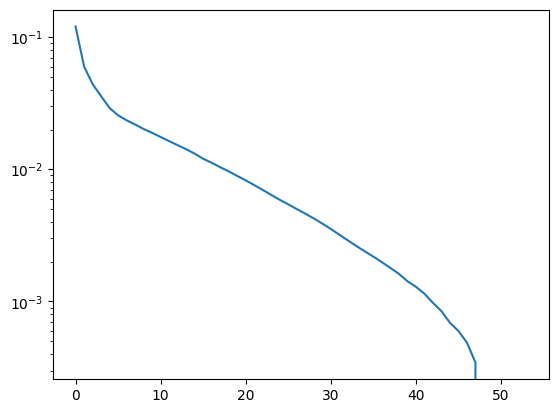

In [17]:
U_svd, S, V_svd = svd(imgs[i, :, :])
# plt.semilogy(S)
plt.semilogy(np.sqrt(np.linalg.norm(S)**2 - np.cumsum(S**2)) / np.linalg.norm(S))

# Visualization

In [2]:
%tensorboard --logdir "../data/output/runs"

# References

1. <a id='r1'></a> De Handschutter, P., Gillis, N., & Siebert, X. (2021). A survey on deep matrix factorizations. Computer Science Review, 42, 100423. https://doi.org/10.1016/j.cosrev.2021.100423
2. <a id='r2'></a> Sun, J., Kong, Q., & Xu, Z. (2022). Deep alternating non-negative matrix factorisation. Knowledge-Based Systems, 251, 109210. https://doi.org/10.1016/j.knosys.2022.109210


